<h2><center>American Sign Language Detection</center></h2>

### 1. Importing packages <a id=1></a>

In [1]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

print("Packages imported...")

2024-06-06 15:42:42.810803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 15:42:42.810969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 15:42:42.966243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Packages imported...


### 2. Importing the dataset from training directory <a id=2></a>

In [2]:
import os
import numpy as np
import cv2
import skimage.transform

batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29

train_len = 87000
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

def get_data(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=int)
    cnt = 0
    label_dict = {
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,
        'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16,
        'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24,
        'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
    }
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            label = label_dict.get(folderName, 29)
            for image_filename in os.listdir(os.path.join(folder, folderName)):
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    X[cnt] = img_file
                    y[cnt] = label
                    cnt += 1
    return X, y

X_train, y_train = get_data(train_dir)
print("Images successfully imported...")


Images successfully imported...


#### 2.1 Checking the shape of data <a id=3></a>

In [3]:
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)

The shape of X_train is :  (87000, 64, 64, 3)
The shape of y_train is :  (87000,)


#### 2.2 Checking the shape of one image <a id=4></a>

In [4]:
print("The shape of one image is : ", X_train[0].shape)

The shape of one image is :  (64, 64, 3)


#### 2.3 Viewing the image <a id=5></a>

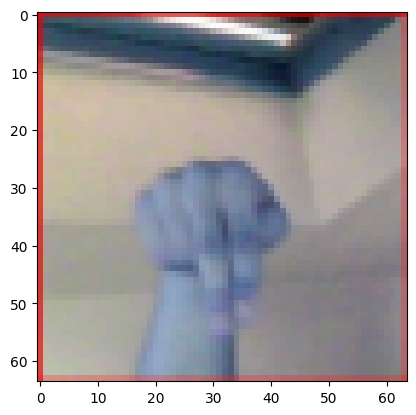

In [5]:
plt.imshow(X_train[0])
plt.show()

##### 2.3.1 Making copies of original data

In [6]:
X_data = X_train
y_data = y_train
print("Copies made...")

Copies made...


### 3. Data processing <a id=6></a>

#### 3.1 Train/test split <a id=7></a>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

#### 3.2 One-Hot-Encoding <a id=8></a>

In [8]:
# One-Hot-Encoding the categorical data
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

#### 3.3 Dimension Check of variables <a id=9></a>

In [9]:
# Checking the dimensions of all the variables
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_cat_train.shape)
print(y_cat_test.shape)

(60900, 64, 64, 3)
(60900,)
(26100, 64, 64, 3)
(26100,)
(60900, 29)
(26100, 29)


### 4. Garbage Collection <a id=10></a>

In [10]:
# This is done to save CPU and RAM space while working on Kaggle Kernels. This will delete the specified data and save some space!
import gc
del X_data
del y_data
gc.collect()

3513

### 5. Modeling <a id=11></a>

#### 5.1 Importing packages <a id=12></a>

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
print("Packages imported...")

Packages imported...


#### 5.2 Building model <a id=13></a>

In [12]:
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(29, activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,637 (1.36 MB)

 Trainable params: 356,637 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Save the model architecture to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot
Image(filename='model_architecture.png')


#### 5.3 Early Stopping and Compiling <a id=14></a>

##### 5.3.1 Early Stopping

Early Stopping is done to make sure the model fitting stops at the most optimized accuracy point. After the early stopping point, the model might start overfitting. For testing purposes, this step can be skipped and complete training can be done.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

##### 5.3.2 Compiling

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### 5.4 Model fitting <a id=15></a>

In [19]:
model.fit(X_train, y_cat_train,
          epochs=50,
          batch_size=32,
          verbose=2,
          validation_data=(X_test, y_cat_test),
         callbacks=[early_stop])

Epoch 1/50
1904/1904 - 205s - 108ms/step - accuracy: 0.7607 - loss: 0.7847 - val_accuracy: 0.9330 - val_loss: 0.2152
Epoch 2/50
1904/1904 - 196s - 103ms/step - accuracy: 0.9648 - loss: 0.1091 - val_accuracy: 0.9808 - val_loss: 0.0618
Epoch 3/50
1904/1904 - 191s - 100ms/step - accuracy: 0.9796 - loss: 0.0637 - val_accuracy: 0.9758 - val_loss: 0.0820
Epoch 4/50
1904/1904 - 191s - 100ms/step - accuracy: 0.9855 - loss: 0.0465 - val_accuracy: 0.9854 - val_loss: 0.0465
Epoch 5/50
1904/1904 - 193s - 101ms/step - accuracy: 0.9882 - loss: 0.0403 - val_accuracy: 0.9846 - val_loss: 0.0461
Epoch 6/50
1904/1904 - 191s - 100ms/step - accuracy: 0.9904 - loss: 0.0316 - val_accuracy: 0.9878 - val_loss: 0.0383
Epoch 7/50
1904/1904 - 203s - 107ms/step - accuracy: 0.9926 - loss: 0.0280 - val_accuracy: 0.9928 - val_loss: 0.0250
Epoch 8/50
1904/1904 - 192s - 101ms/step - accuracy: 0.9919 - loss: 0.0302 - val_accuracy: 0.9931 - val_loss: 0.0201
Epoch 9/50
1904/1904 - 201s - 106ms/step - accuracy: 0.9952 - lo

#### 5.5 Model metrics <a id=16></a>

##### 5.5.1 Metrics from model history

In [20]:
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


,accuracy,loss,val_accuracy,val_loss
0,0.760673,0.784711,0.933027,0.215203
1,0.964778,0.109106,0.980766,0.061792
2,0.979589,0.063747,0.975785,0.081974
3,0.985468,0.046535,0.985402,0.046541
4,0.988177,0.040297,0.984598,0.046097
5,0.990411,0.031576,0.987778,0.038256
6,0.992627,0.027991,0.992759,0.024962
7,0.991938,0.030152,0.993142,0.020055
8,0.995189,0.017033,0.990077,0.035506
9,0.993136,0.023309,0.987510,0.041037


##### 5.5.2 Plotting the training loss

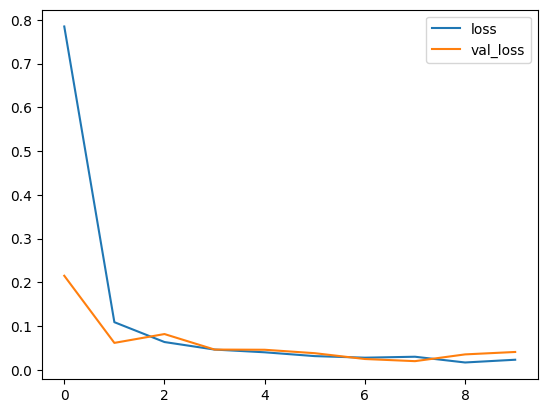

In [21]:
metrics[['loss','val_loss']].plot()
plt.show()

##### 5.5.3 Plotting the testing loss

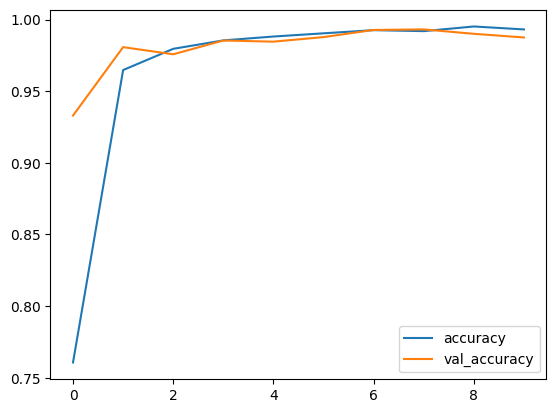

In [22]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

##### 5.5.4 Model evaluation

In [23]:
model.evaluate(X_test,y_cat_test,verbose=0)

[0.0410374291241169, 0.9875096082687378]

#### 5.6 Predictions <a id=17></a>

In [24]:
import numpy as np

# Assuming X_test is your test dataset
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
print("Predictions done...")


816/816 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step
Predictions done...


##### 5.6.1 Classification report

In [25]:
import numpy as np

# Assuming X_test is your test dataset and model is your trained model
predictions_prob = model.predict(X_test)
predictions = np.argmax(predictions_prob, axis=1)


816/816 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step


In [26]:
if len(y_test.shape) == 2 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       900
           1       0.98      0.99      0.98       900
           2       1.00      0.99      1.00       900
           3       1.00      1.00      1.00       900
           4       1.00      0.94      0.97       900
           5       0.99      1.00      0.99       900
           6       1.00      1.00      1.00       900
           7       1.00      0.99      1.00       900
           8       0.97      1.00      0.99       900
           9       1.00      1.00      1.00       900
          10       0.97      0.99      0.98       900
          11       0.99      1.00      0.99       900
          12       0.97      1.00      0.98       900
          13       1.00      0.98      0.99       900
          14       0.96      1.00      0.98       900
          15       0.98      1.00      0.99       900
          16       1.00      0.99      1.00       900
          17       0.97    

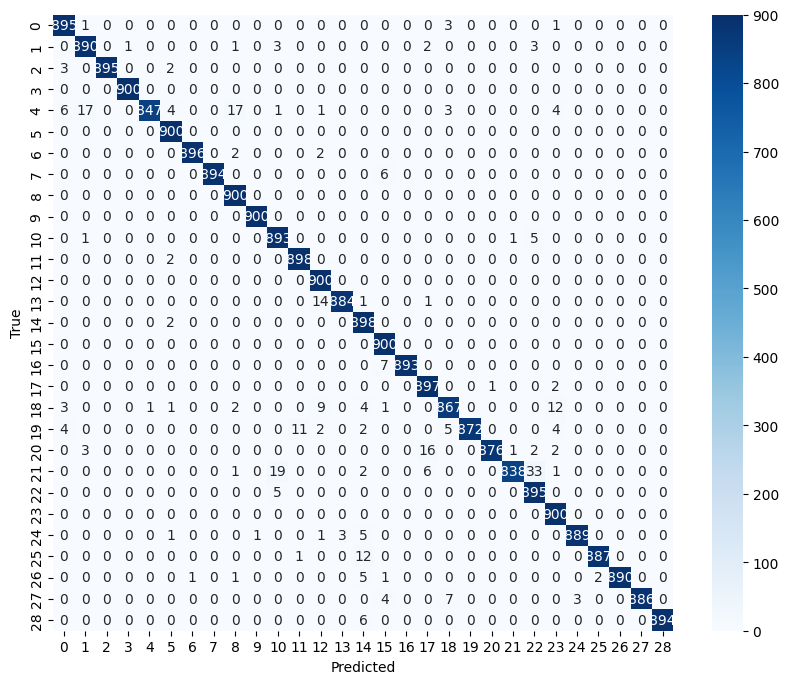

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


##### 5.6.2 Confusion matrix heatmap

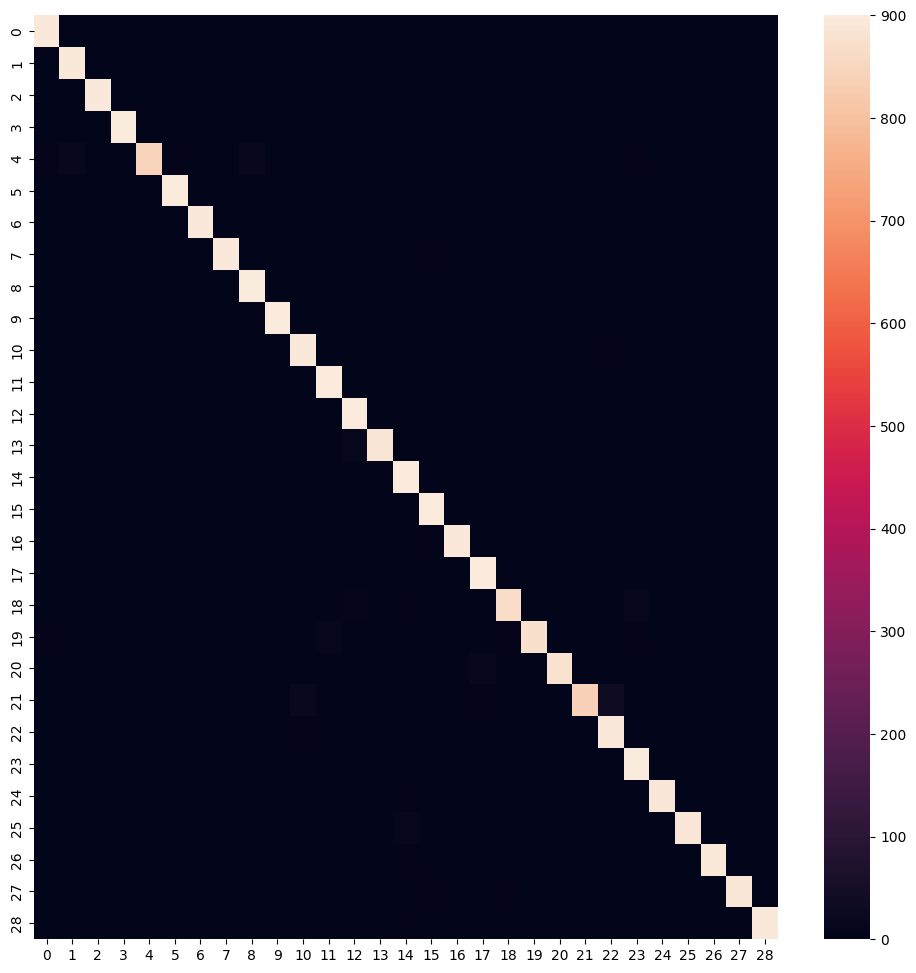

In [28]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()

#### 5.7 Saving the model <a id=18></a>

In [29]:
model.save("tgmt_hand_v03_1.h5")


# **5.8 test image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted label: Y


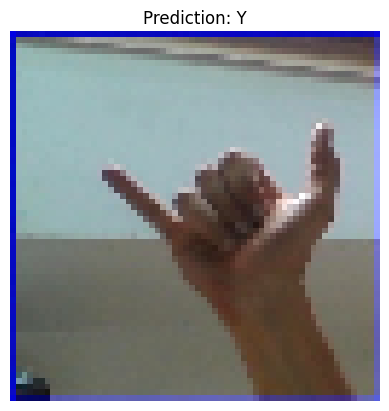

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Đường dẫn đến mô hình đã lưu
model_path = '/kaggle/working/tgmt_hand_v03_1.h5'
# Tải mô hình đã huấn luyện
model = load_model(model_path)

# Đường dẫn đến ảnh test
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/Y_test.jpg'

# Tải ảnh và xử lý ảnh
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Chuẩn hóa ảnh

# Dự đoán
prediction = model.predict(img)
predicted_class = np.argmax(prediction, axis=1)

# Định nghĩa lại từ điển nhãn
label_dict = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
    17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
    25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

# In ra kết quả dự đoán
predicted_label = label_dict[predicted_class[0]]
print(f'Predicted label: {predicted_label}')

# Hiển thị ảnh
plt.imshow(new_img)
plt.title(f'Prediction: {predicted_label}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted label: W


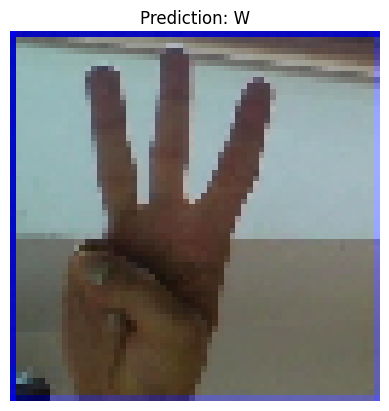

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Đường dẫn đến mô hình đã lưu
model_path = '/kaggle/working/tgmt_hand_v03_1.h5'
# Tải mô hình đã huấn luyện
model = load_model(model_path)

# Đường dẫn đến ảnh test
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/W_test.jpg'

# Tải ảnh và xử lý ảnh
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Chuẩn hóa ảnh

# Dự đoán
prediction = model.predict(img)
predicted_class = np.argmax(prediction, axis=1)

# Định nghĩa lại từ điển nhãn
label_dict = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
    17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
    25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

# In ra kết quả dự đoán
predicted_label = label_dict[predicted_class[0]]
print(f'Predicted label: {predicted_label}')

# Hiển thị ảnh
plt.imshow(new_img)
plt.title(f'Prediction: {predicted_label}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted label: Q


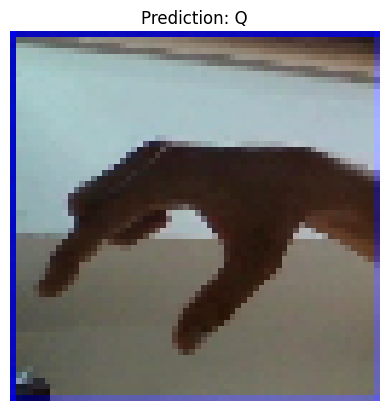

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Đường dẫn đến mô hình đã lưu
model_path = '/kaggle/working/tgmt_hand_v03_1.h5'
# Tải mô hình đã huấn luyện
model = load_model(model_path)

# Đường dẫn đến ảnh test
image_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/Q_test.jpg'

# Tải ảnh và xử lý ảnh
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Chuẩn hóa ảnh

# Dự đoán
prediction = model.predict(img)
predicted_class = np.argmax(prediction, axis=1)

# Định nghĩa lại từ điển nhãn
label_dict = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
    17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
    25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

# In ra kết quả dự đoán
predicted_label = label_dict[predicted_class[0]]
print(f'Predicted label: {predicted_label}')

# Hiển thị ảnh
plt.imshow(new_img)
plt.title(f'Prediction: {predicted_label}')
plt.axis('off')
plt.show()
